## Analyse Israel vaccine efficacy

In [1]:
import pandas as pd
import sys
sys.path.append("../")
import numpy as np
pd.set_option('display.max_rows', 500)
from datetime import datetime, timedelta
from utils import createXYPlot, get_efficacy
import subprocess
from functools import reduce

#### Download data manyally from put it in ./data (could not find an automated way)
https://data.gov.il/dataset/covid-19/resource/8a51c65b-f95a-4fb8-bd97-65f47109f41f/download/event-among-vaccinated-25.csv

In [2]:
df=pd.read_csv("./data/event-among-vaccinated-25.csv")
df["event_2nd_dose"] = df["event_after_2nd_dose"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["event_1st_dose"] = df["event_after_1st_dose"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["event_no_vax"] = df["event_for_not_vaccinated"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["first_day"] = df["Week"].apply(lambda x: x.split(" - ")[0])
df["last_day"] = df["Week"].apply(lambda x: x.split(" - ")[1])
df=df.fillna(0)
df["over_60"]=df["Age_group"].apply(lambda x: "over_60" if x in ('60-69','70-79','80-89','90+') else "under_60")
df = df.rename(columns={"Age_group":"age_group",
                        "Week":"week",
                       "Type_of_event":"type_of_event"})
df = df[["week","first_day","last_day","age_group","over_60","type_of_event","event_1st_dose","event_2nd_dose","event_no_vax"]]

In [3]:
df

,week,first_day,last_day,age_group,over_60,type_of_event,event_1st_dose,event_2nd_dose,event_no_vax
0,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,0-19,under_60,Hospitalization,0.0,0.0,56.0
1,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,0-19,under_60,Death,0.0,0.0,0.0
2,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,20-29,under_60,Hospitalization,0.0,0.0,50.0
3,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,20-29,under_60,Death,0.0,0.0,4.0
4,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,30-39,under_60,Hospitalization,0.0,0.0,79.0
...,...,...,...,...,...,...,...,...,...
517,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,70-79,over_60,Death,0.0,4.0,0.0
518,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,80-89,over_60,Hospitalization,0.0,9.0,4.0
519,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,80-89,over_60,Death,0.0,4.0,0.0
520,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,90+,over_60,Hospitalization,0.0,4.0,0.0


In [4]:
last_day=str(np.max(df["last_day"]))
print(f"Last available data: {last_day}")

Last available data: 2021-07-10


In [5]:
print("Creating plot folder")
plot_folder = f"./plots/{last_day}"
subprocess.run(f"mkdir -p {plot_folder}", shell=True)

Creating plot folder


CompletedProcess(args='mkdir -p ./plots/2021-07-10', returncode=0)

In [6]:
types = df.type_of_event.unique()
print(f"Types of event: {types}")

Types of event: ['Hospitalization' 'Death']


In [7]:
df_events = {}
for event in types:
    df_events[event] = df[df.type_of_event==event].groupby(["week", "first_day", "last_day"]).agg(
        event_1st_dose=("event_1st_dose","sum"),
        event_2nd_dose=("event_2nd_dose","sum"),
        event_no_vax=("event_no_vax","sum"),
    ).reset_index() 

In [8]:
display(df_events["Hospitalization"].head(10))
display(df_events["Hospitalization"].tail(10))

,week,first_day,last_day,event_1st_dose,event_2nd_dose,event_no_vax
0,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,12.0,0.0,1041.0
1,2020-12-27 - 2021-01-02,2020-12-27,2021-01-02,83.0,0.0,1181.0
2,2021-01-03 - 2021-01-09,2021-01-03,2021-01-09,438.0,0.0,1256.0
3,2021-01-10 - 2021-01-16,2021-01-10,2021-01-16,694.0,4.0,1119.0
4,2021-01-17 - 2021-01-23,2021-01-17,2021-01-23,584.0,46.0,1114.0
5,2021-01-24 - 2021-01-30,2021-01-24,2021-01-30,340.0,147.0,992.0
6,2021-01-31 - 2021-02-06,2021-01-31,2021-02-06,260.0,166.0,1080.0
7,2021-02-07 - 2021-02-13,2021-02-07,2021-02-13,185.0,110.0,1000.0
8,2021-02-14 - 2021-02-20,2021-02-14,2021-02-20,139.0,89.0,862.0
9,2021-02-21 - 2021-02-27,2021-02-21,2021-02-27,161.0,81.0,817.0


,week,first_day,last_day,event_1st_dose,event_2nd_dose,event_no_vax
19,2021-05-02 - 2021-05-08,2021-05-02,2021-05-08,12.0,20.0,39.0
20,2021-05-09 - 2021-05-15,2021-05-09,2021-05-15,12.0,20.0,32.0
21,2021-05-16 - 2021-05-22,2021-05-16,2021-05-22,0.0,24.0,32.0
22,2021-05-23 - 2021-05-29,2021-05-23,2021-05-29,16.0,24.0,28.0
23,2021-05-30 - 2021-06-05,2021-05-30,2021-06-05,4.0,24.0,29.0
24,2021-06-06 - 2021-06-12,2021-06-06,2021-06-12,12.0,20.0,20.0
25,2021-06-13 - 2021-06-19,2021-06-13,2021-06-19,8.0,28.0,12.0
26,2021-06-20 - 2021-06-26,2021-06-20,2021-06-26,12.0,16.0,32.0
27,2021-06-27 - 2021-07-03,2021-06-27,2021-07-03,8.0,37.0,36.0
28,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,12.0,63.0,32.0


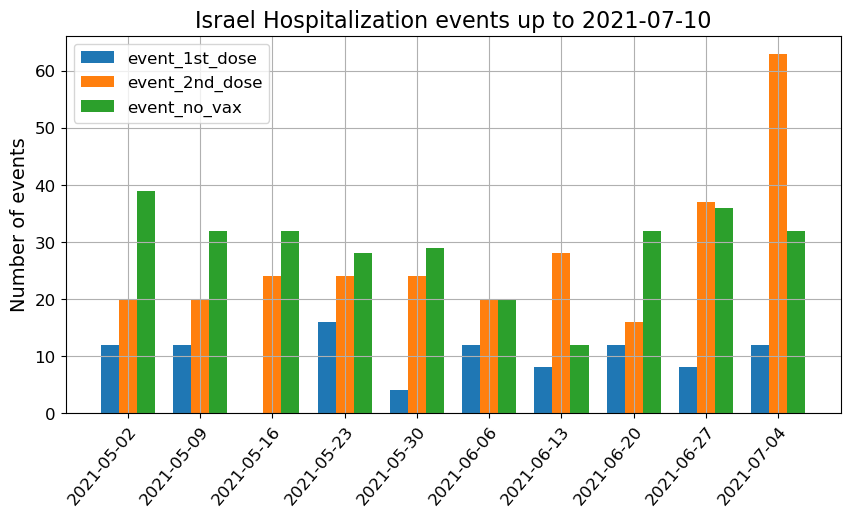

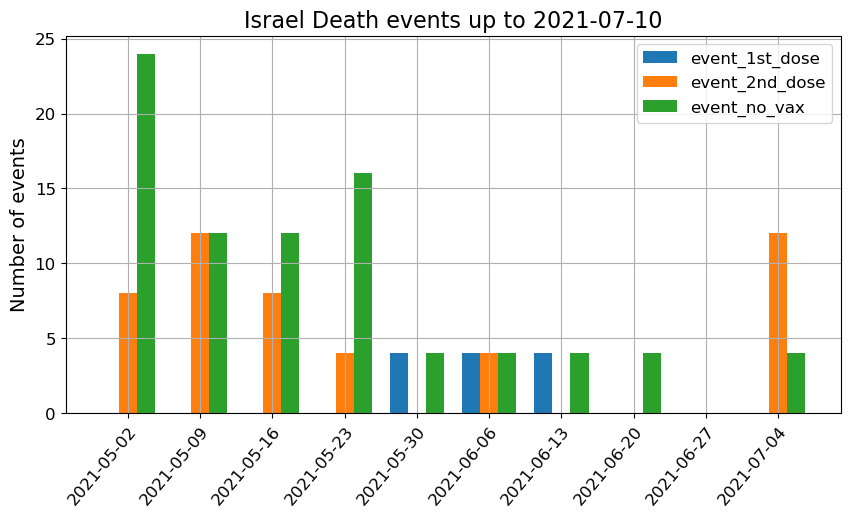

In [9]:
for event in types:
    createXYPlot(df_events[event],
                 y=["event_1st_dose",
                    "event_2nd_dose",
                    "event_no_vax"],
                 today=last_day,
                 plots_folder=plot_folder,
                 x="first_day",
                 linewidth=2,
                 start_date="2021-05-01",
                 days_interval=1,
                 bar=True,
                 alpha=1,
                 bar_width=0.25,
                 bar_start=[-1,0,1],
                 title=f"Israel {event} events up to {last_day}",
                 xtitle=None,
                 ytitle="Number of events",
                 savename=f"Israel_{event}_events_vax"
                )

### Split by age groups

In [10]:
df_events_age = {}
for event in types:
    df_events_age[event] = df[df.type_of_event==event].groupby(["week", "first_day", "last_day", "age_group","over_60"]).agg(
        event_1st_dose=("event_1st_dose","sum"),
        event_2nd_dose=("event_2nd_dose","sum"),
        event_no_vax=("event_no_vax","sum"),
    ).reset_index()


In [11]:
age_groups = sorted(df["age_group"].unique())
print(f"Age groups: {age_groups}")

Age groups: ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']


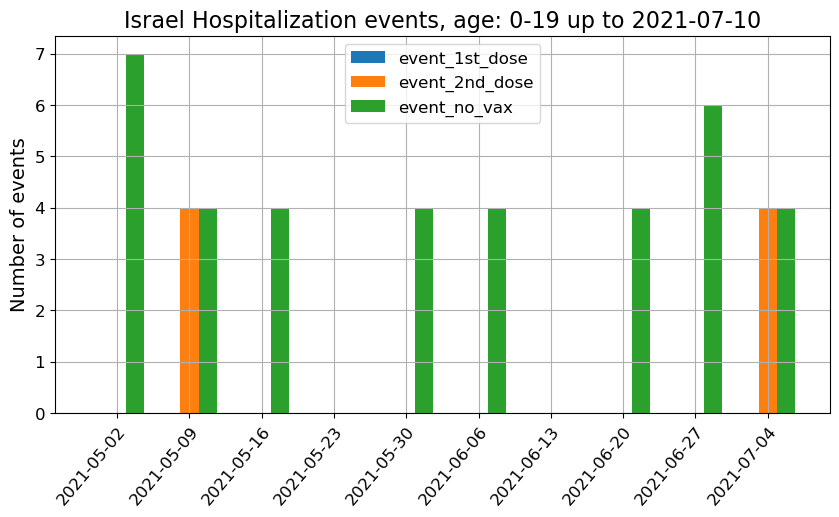

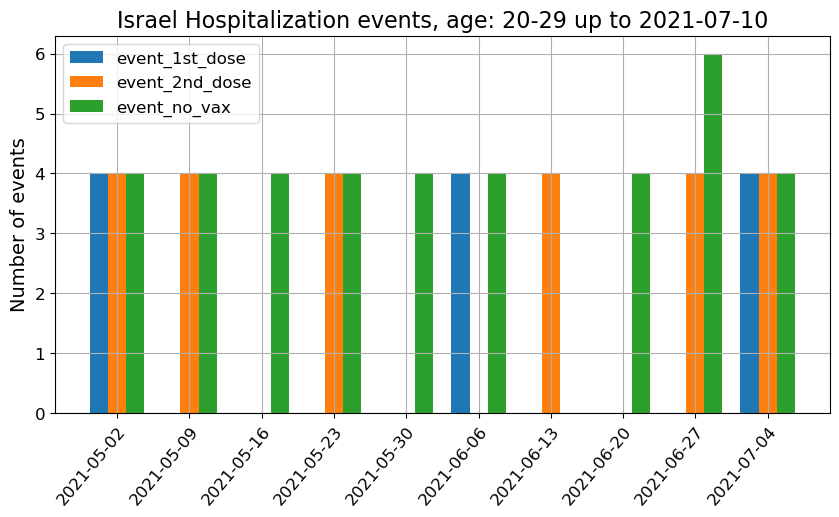

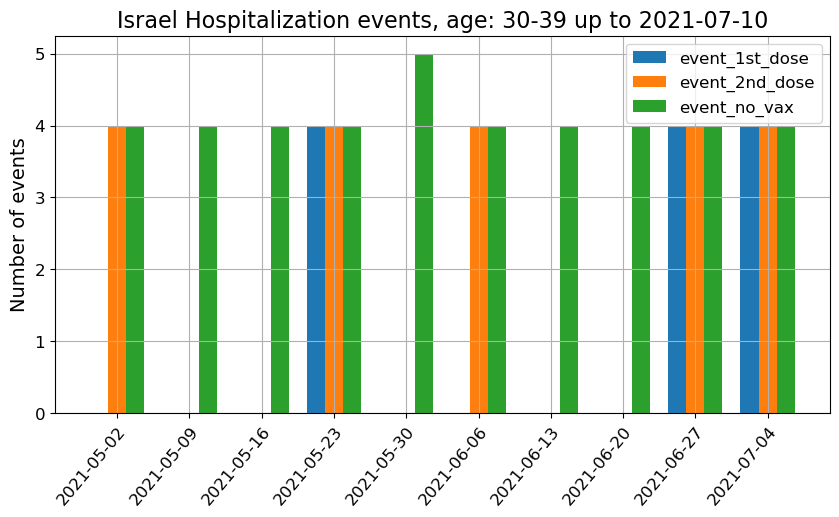

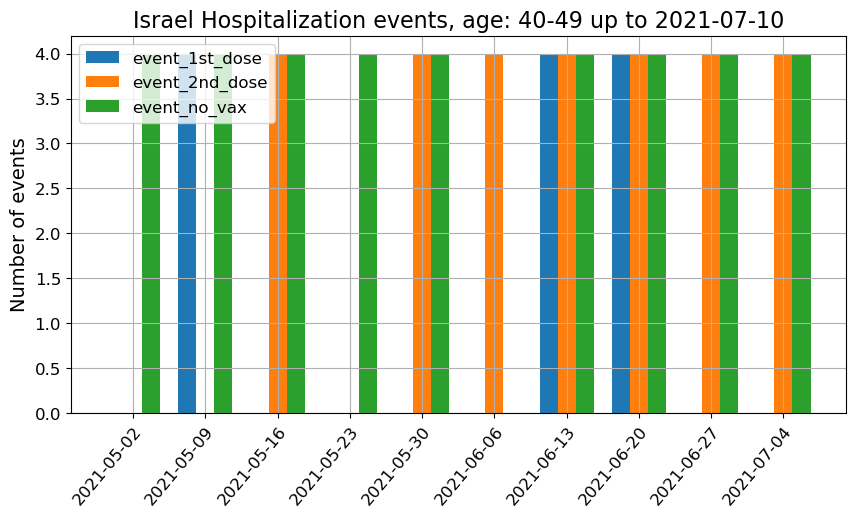

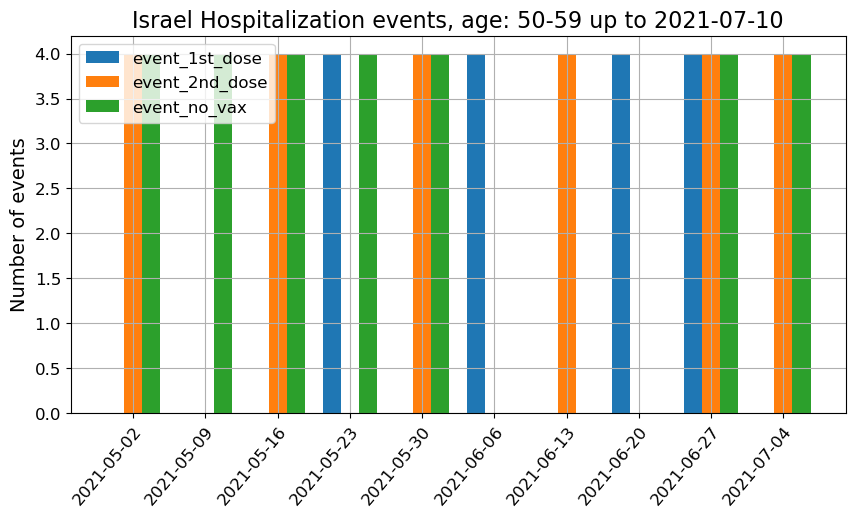

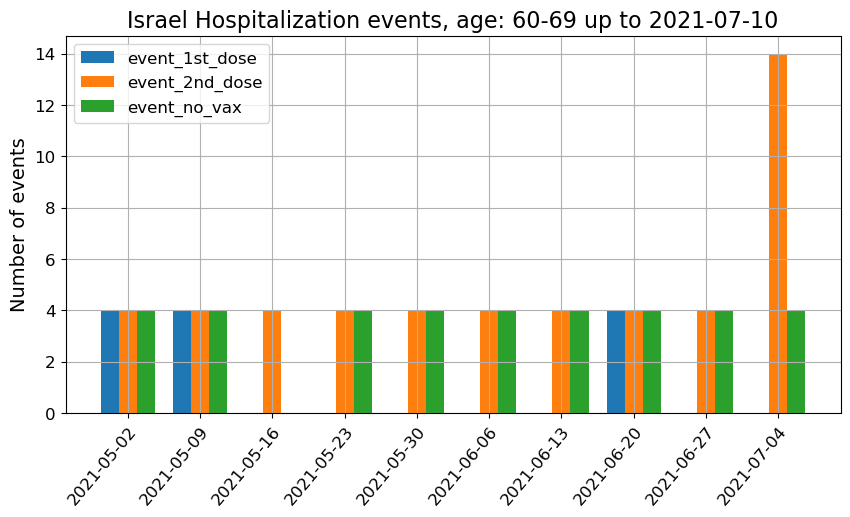

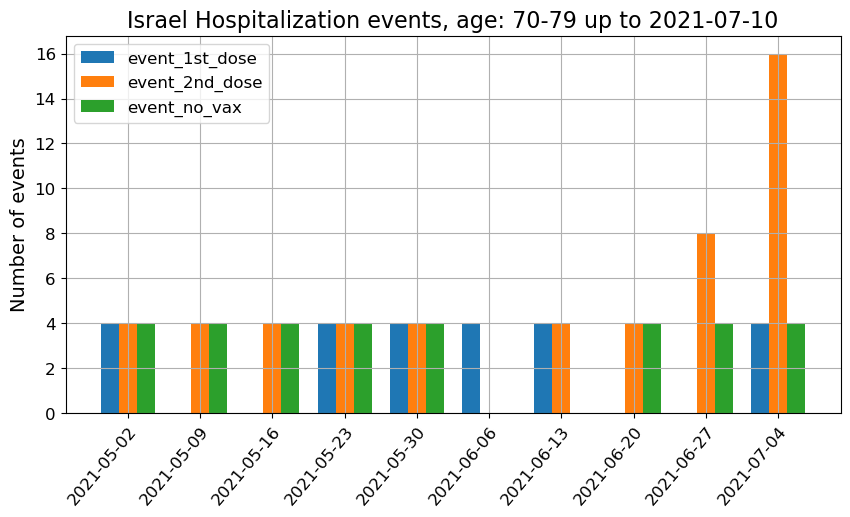

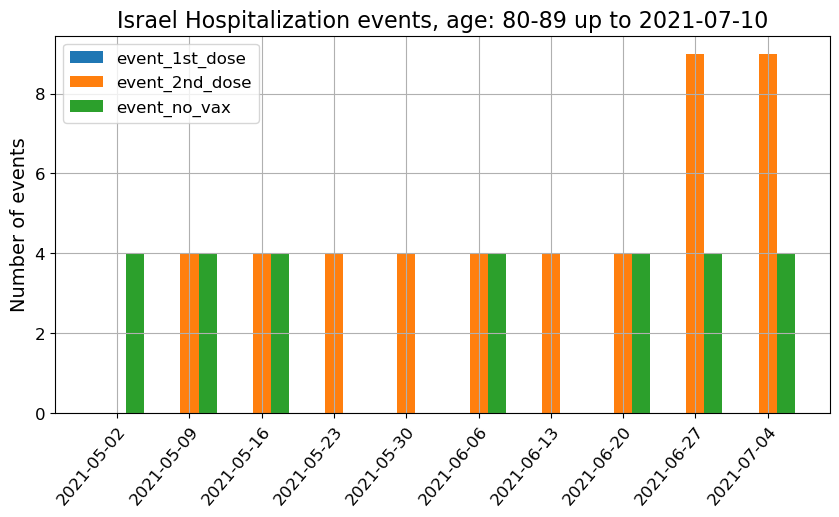

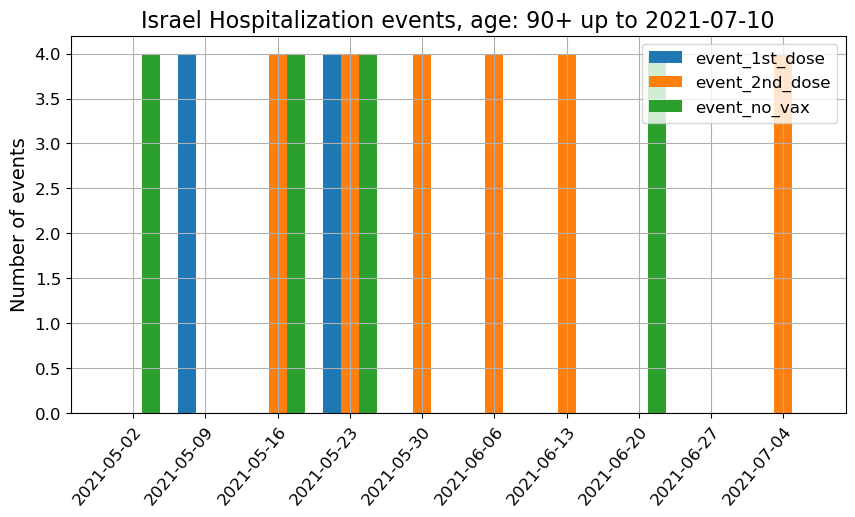

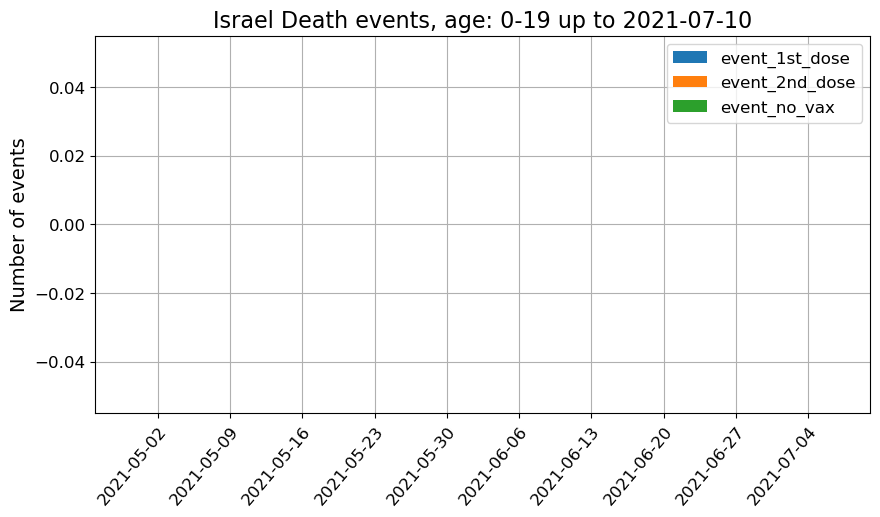

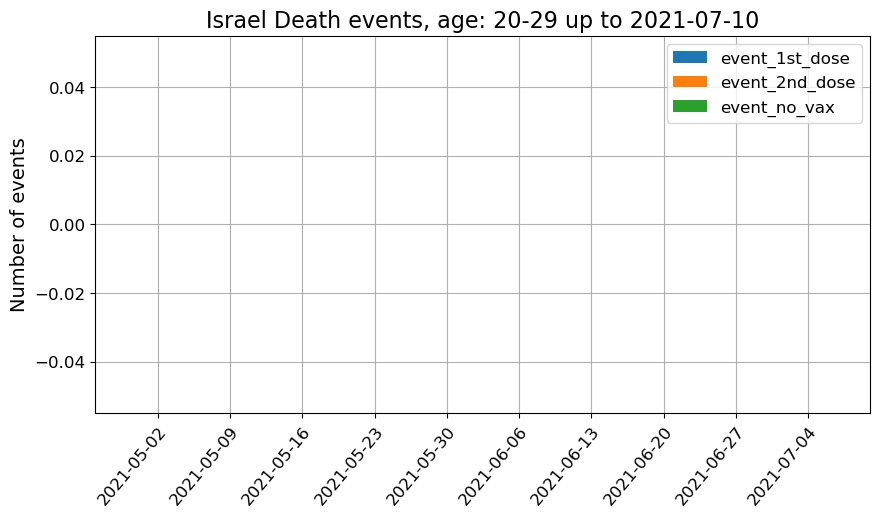

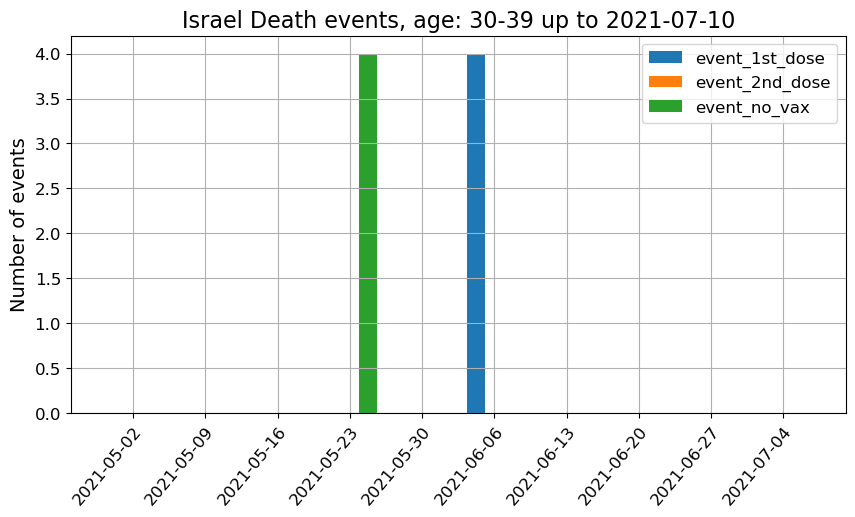

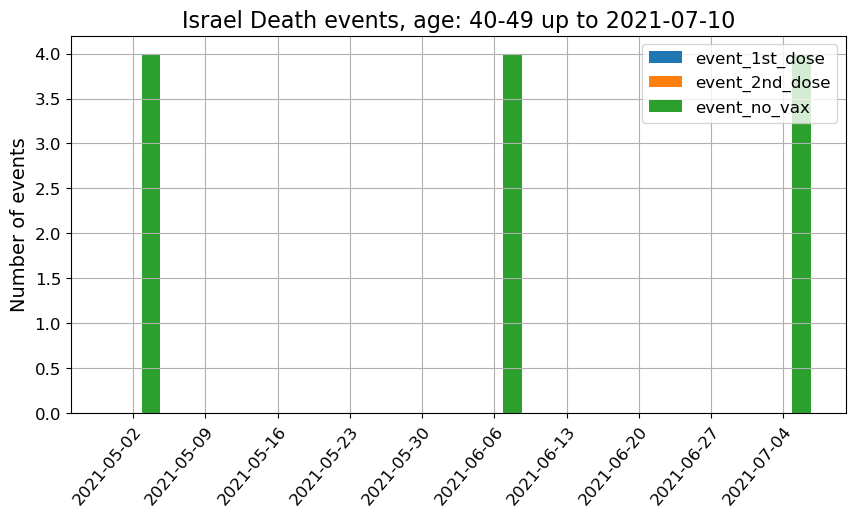

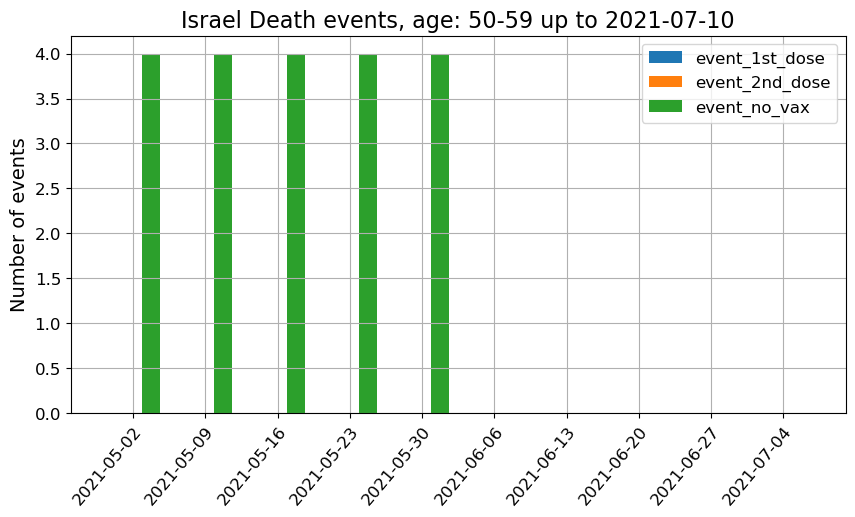

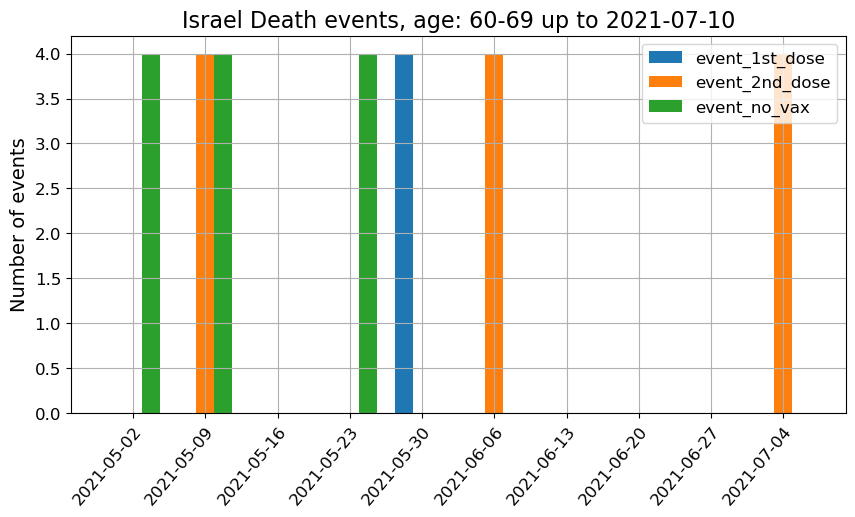

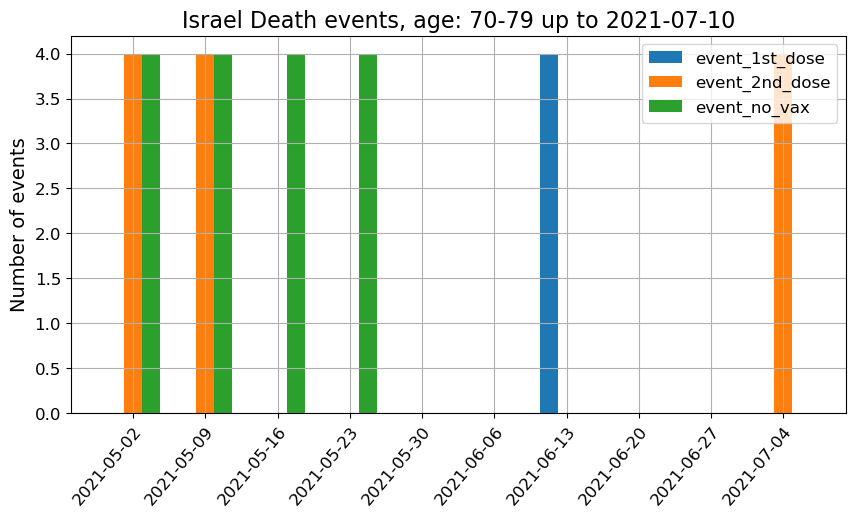

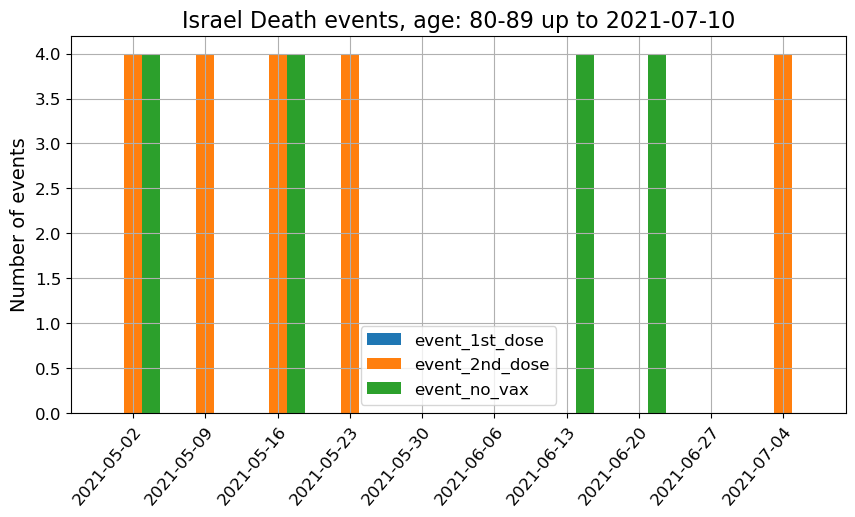

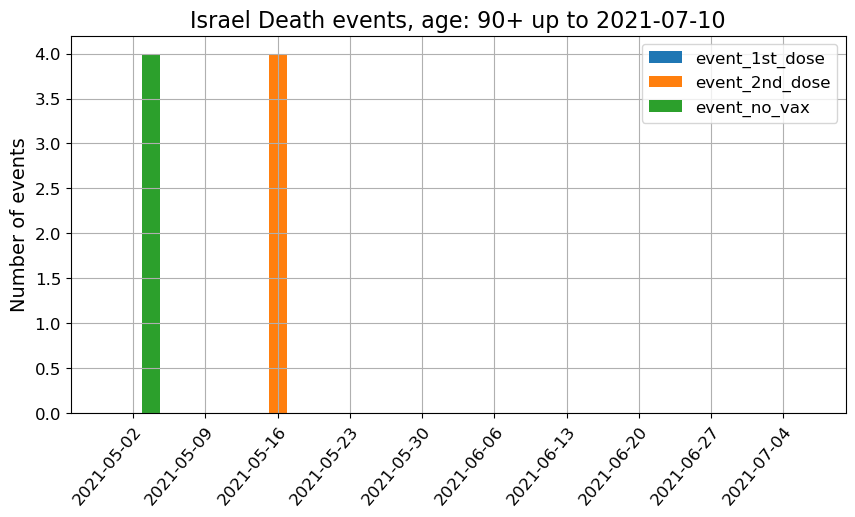

In [12]:
for event in types:
    for age in age_groups:
        createXYPlot(df_events_age[event][df_events_age[event]["age_group"]==age],
                 y=["event_1st_dose",
                    "event_2nd_dose",
                    "event_no_vax"],
                 today=last_day,
                 plots_folder=plot_folder,
                 x="first_day",
                 linewidth=2,
                 start_date="2021-05-01",
                 days_interval=1,
                 bar=True,
                 alpha=1,
                 bar_width=0.25,
                 bar_start=[-1,0,1],
                 title=f"Israel {event} events, age: {age} up to {last_day}",
                 xtitle=None,
                 ytitle="Number of events",
                 savename=f"Israel_{event}_events_{age.replace('-','_')}_vax")

### Vaccinations per day - age_group

https://data.gov.il/dataset/covid-19/resource/57410611-936c-49a6-ac3c-838171055b1f/download/vaccinated-per-day-2021-07-13.csv


In [13]:
df_vax_age = pd.read_csv("./data/vaccinated-per-day-2021-07-13.csv")

In [14]:
df_vax_age["week"] = ((pd.to_datetime(df_vax_age["VaccinationDate"]) - pd.to_datetime("2020-12-20")).dt.days / 7).astype(int)
df_vax_age["over_60"] = df_vax_age["age_group"].apply(lambda x: "over_60" if x in ('60-69','70-79','80-89','90+') else "under_60")
df_vax_age["first_dose"] = df_vax_age["first_dose"].apply(lambda x: int(x.replace("<","")) - 1 if "<" in x else int(x))
df_vax_age["second_dose"] = df_vax_age["second_dose"].apply(lambda x: int(x.replace("<","")) - 1 if "<" in x else int(x))

In [15]:
df_vax_age

,VaccinationDate,age_group,first_dose,second_dose,week,over_60
0,2020-12-20,20-29,392,0,0,under_60
1,2020-12-20,80-89,93,0,0,over_60
2,2020-12-20,0-19,21,0,0,under_60
3,2020-12-20,60-69,1516,0,0,over_60
4,2020-12-20,50-59,1786,0,0,under_60
...,...,...,...,...,...,...
1836,2021-07-13,70-79,31,27,29,over_60
1837,2021-07-13,90+,14,14,29,over_60
1838,2021-07-13,80-89,17,16,29,over_60
1839,2021-07-13,0-19,1501,4296,29,under_60


#### Create grid of dates in case some are missing

In [16]:
min_yyyy_mm_dd = datetime.strptime(np.min(df_vax_age["VaccinationDate"]),"%Y-%m-%d")
max_yyyy_mm_dd = datetime.strptime(np.max(df_vax_age["VaccinationDate"]),"%Y-%m-%d")
print(f"min day: {min_yyyy_mm_dd}")
print(f"max day: {max_yyyy_mm_dd}")
all_yyy_mm_dd = pd.DataFrame([str(i.date()) for i in pd.date_range(min_yyyy_mm_dd, max_yyyy_mm_dd,freq='d')], columns=["VaccinationDate"])
age_groups = df_vax_age["age_group"].unique()
all_age_groups = pd.DataFrame(age_groups,columns=["age_group"])

min day: 2020-12-20 00:00:00
max day: 2021-07-13 00:00:00


In [17]:
all_yyy_mm_dd["key"]=0
all_age_groups["key"]=0
all_yyy_mm_dd=all_yyy_mm_dd.set_index("key")
all_age_groups=all_age_groups.set_index("key")
df_grid=all_yyy_mm_dd.join(all_age_groups).sort_values(by=["VaccinationDate","age_group"]).set_index(["VaccinationDate","age_group"])

In [18]:
display(df_grid.head(10))
display(df_grid.tail(10))

Empty DataFrame
Columns: []
Index: [(2020-12-20, 0-19), (2020-12-20, 20-29), (2020-12-20, 30-39), (2020-12-20, 40-49), (2020-12-20, 50-59), (2020-12-20, 60-69), (2020-12-20, 70-79), (2020-12-20, 80-89), (2020-12-20, 90+), (2020-12-21, 0-19)]

Empty DataFrame
Columns: []
Index: [(2021-07-12, 90+), (2021-07-13, 0-19), (2021-07-13, 20-29), (2021-07-13, 30-39), (2021-07-13, 40-49), (2021-07-13, 50-59), (2021-07-13, 60-69), (2021-07-13, 70-79), (2021-07-13, 80-89), (2021-07-13, 90+)]

In [19]:
df_vax_age = df_grid.join(df_vax_age.set_index(["VaccinationDate","age_group"])).reset_index().fillna({"first_dose":0, "second_dose":0})
df_vax_age["week"] = ((pd.to_datetime(df_vax_age["VaccinationDate"]) - pd.to_datetime("2020-12-20")).dt.days / 7).astype(int)
df_vax_age["over_60"] = df_vax_age["age_group"].apply(lambda x: "over_60" if x in ('60-69','70-79','80-89','90+') else "under_60")
df_vax_age = df_vax_age.sort_values(by=["VaccinationDate","age_group"])

In [20]:
df_vax_age.tail(30)

,VaccinationDate,age_group,first_dose,second_dose,week,over_60
1824,2021-07-10,70-79,25.0,14.0,28,over_60
1825,2021-07-10,80-89,14.0,0.0,28,over_60
1826,2021-07-10,90+,0.0,0.0,28,over_60
1827,2021-07-11,0-19,505.0,1968.0,29,under_60
1828,2021-07-11,20-29,298.0,237.0,29,under_60
1829,2021-07-11,30-39,234.0,219.0,29,under_60
1830,2021-07-11,40-49,171.0,149.0,29,under_60
1831,2021-07-11,50-59,101.0,68.0,29,under_60
1832,2021-07-11,60-69,49.0,65.0,29,over_60
1833,2021-07-11,70-79,20.0,24.0,29,over_60


In [ ]:
for age in age_groups:
    createXYPlot(df_vax_age[df_vax_age.age_group==age],
             y=["first_dose","second_dose"],
             today="",
             plots_folder=plot_folder,
             x="VaccinationDate",
             linewidth=2,
             start_date="2020-12-01",
             days_interval=7,
             bar=False,
             alpha=1,
             bar_width=0.3,
             bar_start=[-1,0,1],
             title=f"Israel vaccinations age:{age} up to {last_day}",
             savename=f"Israel_vaccinations_{age}",
             ytitle="Administered doses"
            )

### Aggregate by week

In [ ]:
df_vax_age_week = df_vax_age.groupby(["week","age_group","over_60"]).agg(first_day=("VaccinationDate","min"),
                                                               last_day=("VaccinationDate","max"),
                                                               first_dose=("first_dose","sum"),
                                                               second_dose=("second_dose","sum")
                                                              ).reset_index()

df_vax_age_week["week"] = df_vax_age_week["first_day"] + " - " + df_vax_age_week["last_day"]
df_vax_age_week = df_vax_age_week.sort_values(by=["week","age_group"])

In [ ]:
df_vax_age_week

In [ ]:
for age in age_groups:
    createXYPlot(df_vax_age_week[df_vax_age.age_group==age],
             y=["first_dose","second_dose"],
             today="",
             plots_folder=plot_folder,
             x="first_day",
             linewidth=2,
             start_date="2020-12-01",
             days_interval=7,
             bar=False,
             alpha=1,
             bar_width=0.3,
             bar_start=[-1,0,1],
             title=f"Israel vaccinations age:{age} up to {last_day}",
             savename=f"Israel_vaccinations_weekly_{age}",
             ytitle="Administered doses"
            )

In [ ]:
df_vax_age_week.head(10)

### Join with events data

In [ ]:
df_event_doses = {}
index_columns=["week","first_day","last_day","age_group","over_60"]
df_events_doses = {}
for event in types:
    df_event_doses[event]=df_events_age[event].set_index(index_columns).join(df_vax_age_week.set_index(index_columns)).fillna(0)

In [ ]:
df_event_doses["Hospitalization"]

### Population
https://www.cbs.gov.il/he/publications/LochutTlushim/2020/%D7%90%D7%95%D7%9B%D7%9C%D7%95%D7%A1%D7%99%D7%99%D7%942019-2000.xlsx

In [ ]:
df_isr_pop=pd.read_csv("./data/israeli_pop.csv")

In [ ]:
df_isr_pop = df_isr_pop[df_isr_pop.age != "total"]
df_isr_pop["age"] = df_isr_pop["age"].apply(lambda x: 90 if x == "90+" else int(x)).astype('int')

In [ ]:
pop_dict = {}
for age_bucket in sorted(age_groups):
    if age_bucket != "90+":
        age_lo = int(age_bucket.split("-")[0])
        age_hi = int(age_bucket.split("-")[1])
    else:
        age_lo = 90
        age_hi = 99999
    print(f"Age lo: {age_lo}, Age hi: {age_hi}")
    df_pop = df_isr_pop[(df_isr_pop.age >= age_lo) &  (df_isr_pop.age <= age_hi)]
    pop_dict[age_bucket] = np.sum(df_pop["pop"])
    
df_pop_strata=pd.DataFrame.from_dict(pop_dict,orient="index",columns=["population"]).sort_index()

In [ ]:
df_pop_strata

In [ ]:
df_event_doses_pop = {}
for event in types:
    df_event_doses_pop[event] = df_event_doses[event].reset_index().set_index("age_group").join(df_pop_strata)
    df_event_doses_pop[event] = df_event_doses_pop[event].reset_index().rename(columns={"index":"age_group"})
    df_event_doses_pop[event] = df_event_doses_pop[event].sort_values(by=["age_group","first_day"])
    df_event_doses_pop[event]["pop_1st_dose"] = df_event_doses_pop[event][["age_group","first_dose"]].groupby("age_group").cumsum()
    df_event_doses_pop[event]["pop_2nd_dose"] = df_event_doses_pop[event][["age_group","second_dose"]].groupby("age_group").cumsum()
    df_event_doses_pop[event]["pop_no_vax"] = df_event_doses_pop[event]["population"] - df_event_doses_pop[event]["pop_1st_dose"]
    df_event_doses_pop[event]["share_1st_dose"] = df_event_doses_pop[event]["pop_1st_dose"]/df_event_doses_pop[event]["population"]
    df_event_doses_pop[event]["share_2nd_dose"] = df_event_doses_pop[event]["pop_2nd_dose"]/df_event_doses_pop[event]["population"]
    df_event_doses_pop[event]["share_no_vax"] = df_event_doses_pop[event]["pop_no_vax"]/df_event_doses_pop[event]["population"]
    
    # For 70-79 100% results vaccinated 
    df_event_doses_pop[event]["share_1st_dose"] = df_event_doses_pop[event]["share_1st_dose"].apply(lambda x: 1 if x > 1 else x)
                                                                  

In [ ]:
for age in sorted(age_groups):
    df_vax_share = df_event_doses_pop["Hospitalization"][df_event_doses_pop["Hospitalization"]["age_group"]==age]
    display(df_vax_share[["week","age_group","pop_1st_dose","population","share_1st_dose","over_60"]].tail(2))

In [ ]:
df_all_ages_vax_latest = df_event_doses_pop["Hospitalization"][df_event_doses_pop["Hospitalization"]["last_day"]==last_day]

tot_1st_dose = np.sum(df_all_ages_vax_latest["pop_1st_dose"])
tot_2nd_dose = np.sum(df_all_ages_vax_latest["pop_2nd_dose"])
tot_population = np.sum(df_all_ages_vax_latest["population"])

print(f"Vaccinated 1st dose: {tot_1st_dose/tot_population}")
print(f"Vaccinated 2nd dose: {tot_2nd_dose/tot_population}")

In [ ]:
for age in age_groups:
    createXYPlot(df_event_doses_pop["Hospitalization"][df_event_doses_pop["Hospitalization"]["age_group"]==age],
                     y=["share_1st_dose","share_2nd_dose"],
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2020-12-01",
                     days_interval=1,
                     bar=False,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel vaccination share {age} up to {last_day}",
                     savename=f"Israel_vaccination_share_{age}"
            )
    

### Aggregate over under/over 60

In [ ]:
df_event_doses_pop_60 = {}
for event in types:
    df_event_doses_pop_60[event] = df_event_doses_pop[event].groupby(["week","first_day","over_60"])\
    .agg(pop_1st_dose=("pop_1st_dose","sum"),
         pop_2nd_dose=("pop_2nd_dose","sum"),
         population=("population","sum")
    ).reset_index()
    df_event_doses_pop_60[event]["pop_no_vax"] = df_event_doses_pop_60[event]["population"] - df_event_doses_pop_60[event]["pop_1st_dose"]

    df_event_doses_pop_60[event]["share_1st_dose"] = df_event_doses_pop_60[event]["pop_1st_dose"]/df_event_doses_pop_60[event]["population"]
    df_event_doses_pop_60[event]["share_2nd_dose"] = df_event_doses_pop_60[event]["pop_2nd_dose"]/df_event_doses_pop_60[event]["population"]
    df_event_doses_pop_60[event]["share_no_vax"] = df_event_doses_pop_60[event]["pop_no_vax"]/df_event_doses_pop_60[event]["population"]

In [ ]:
df_event_doses_pop_60["Hospitalization"]

In [ ]:
for age in ["under_60","over_60"]:
    createXYPlot(df_event_doses_pop_60["Hospitalization"][df_event_doses_pop_60["Hospitalization"]["over_60"]==age],
                     y=["share_1st_dose","share_2nd_dose"],
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2020-12-01",
                     days_interval=1,
                     bar=False,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel vaccination share {age} up to {last_day}",
                     savename=f"Israel_vaccination_share_{age}"
            )
    

In [ ]:
df_event_age_doses = {}
for event in ["Hospitalization"]:
    df_ages = {}
    for age in sorted(age_groups):
        print(f"Event: {event}")
        print(f"Age group: {age}")
        df_final = df_event_doses_pop[event][df_event_doses_pop[event]["age_group"] == age]
        df_final = df_final.sort_values(by=["first_day"])
        
        
        df_ages[age] = get_efficacy(df_final)
        
        display(df_final[["week","ev_1st_dose_per_100k","ev_2nd_dose_per_100k","ev_no_vax_per_100k","efficacy_1st_dose",
                          "efficacy_2nd_dose","err_efficacy_2nd_dose"]].tail(4))
        
        createXYPlot(df_final,
                     y=["ev_1st_dose_per_100k",
                        "ev_2nd_dose_per_100k",
                        "ev_no_vax_per_100k"],
                     error=True,
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2021-06-01",
                     days_interval=1,
                     bar=True,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel {event} events per 100k {age} up to {last_day}",
                     savename=f"Israel_{event}_events_per_100k_{age}"
            )
        
        createXYPlot(df_final,
                     y=["efficacy_1st_dose",
                        "efficacy_2nd_dose"],
                     error=False,
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2021-06-01",
                     days_interval=1,
                     bar=False,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel {event} events per 100k {age} up to {last_day}",
                     savename=f"Efficacy_{event}_{age}"
            )
        
    
    df_event_age_doses[event] = df_ages
    

In [ ]:
df_event_doses_pop[event].groupby(["week","first_day"]).agg(
                                event_1st_dose=('event_1st_dose','sum'),
                                event_2nd_dose=('event_2nd_dose','sum'),
                                event_no_vax=('event_no_vax','sum'),
                                pop_1st_dose=('pop_1st_dose','sum'),
                                pop_2nd_dose=('pop_2nd_dose','sum'),
                                pop_no_vax=('pop_no_vax','sum')
                               ).reset_index()